**Test your model**

This file allows you to load in a model, test it against unseen data, unnormalize the results, etc.

In [ ]:
# Load in your model

# model based on data from t [0.25, 50.25] c [0.6, 1.4] MAE = .007

#redfine custom_loss_function
def custom_loss_function(y_true, y_pred):
  loss = tf.cond(tf.math.less(tf.math.reduce_min(y_pred), 0), lambda: float(10**6) * tf.square(y_true - y_pred), lambda: (0.1) * tf.square(tf.math.reduce_sum(y_pred) - tf.math.reduce_sum(y_true)) + tf.square(y_true - y_pred))
  return tf.reduce_mean(loss, axis=-1)

#load model
from keras.models import load_model
model = load_model('plane_IC_model.h5', custom_objects={'custom_loss_function': custom_loss_function})

#lets try a sample of test cases the model has not seen yet



**Process Test Data that the model has not seen**

In [ ]:
#Process Test Data

## plane_ic structure
# keys are times
# solution matrix contains
# 0 - xs
# 1 - phi (solution)
# 2 - uncollided solution

# plane_IC contions
# 0 - t
# 1 - x0 or sigma
# 2 - c (scattering ratio)

import h5py
import numpy as np
import math
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
from sklearn.preprocessing import Normalizer

f = h5py.File('plane_IC_test.hdf5')
g = h5py.File('plane_IC_test_conditions.hdf5')



keysF= []
keysG = []
valuesF = []
valuesG = []
solv1 = []
solv2 = []
solv3 = []
iv1 = []
iv2 = []
iv3 = []




itemsF = f['plane_IC'].items()
itemsG = g['plane_IC'].items()


for itemF in itemsF:
    keysF.append(itemF[0]), valuesF.append(itemF[1])
for itemG in itemsG:
    keysG.append(itemG[0]), valuesG.append(itemG[1])

for i in range(len(keysF)):
    solv1.append(valuesF[i][0])
    solv2.append(valuesF[i][1])
    solv3.append(valuesF[i][2])

for i in range(len(keysG)):
    iv1.append(valuesG[i][0])
    iv2.append(valuesG[i][1])
    iv3.append(valuesG[i][2])

solv1 = np.array(solv1)
solv2 = np.array(solv2)
solv3 = np.array(solv3)
iv1 = np.squeeze(np.array(iv1))
iv2 = np.squeeze(np.array(iv2))
iv3 = np.squeeze(np.array(iv3))

tpnts, npnts = solv1.shape
npntsv = np.linspace(npnts, npnts, tpnts)
#npntsvn = npntsv/np.linalg.norm(npntsv)

#neglecting x0 or simga for this case
ics = np.array([iv1, iv3])
ics = ics.transpose()
ics_norm = normalize(ics, norm='l2')
sols = solv2 #[:,0:1]
sols_norm = normalize(sols, norm='l2')


**Obtain results of the model on the unseen test data**

In [ ]:
#run model on test data

yhat = model.predict(ics_norm)

32/32 [==============================] - 0s 2ms/step


**For quick results, plot normalized results from test data versus neural network solution.**

t = 36.44338 c =  0.87015843


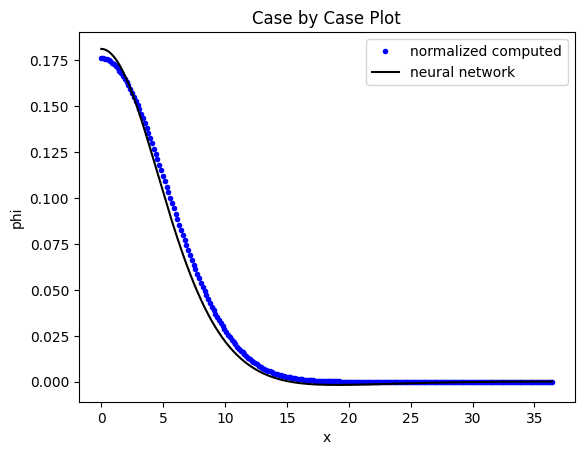

In [ ]:
#check cases with data model has not seen, same parameters as trained but run again
import matplotlib.pyplot as plt

#enter a test case (0-999)
tcase = 600

plt.figure(1)
plt.title("Case by Case Plot")
plt.plot(solv1[tcase, :], sols_norm[tcase] , 'b.', label = "normalized computed")
#plt.plot(solv1[tcase, :], sols[tcase] , 'r.', label = "not normal")
print('t =', iv1[tcase], 'c = ', iv3[tcase])
plt.plot(solv1[tcase, :], yhat[tcase, :] , 'k-', label = "neural network")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.show()


**For experimentation, enter custom initial conditons to see results of neural network**

1/1 [==============================] - 0s 19ms/step


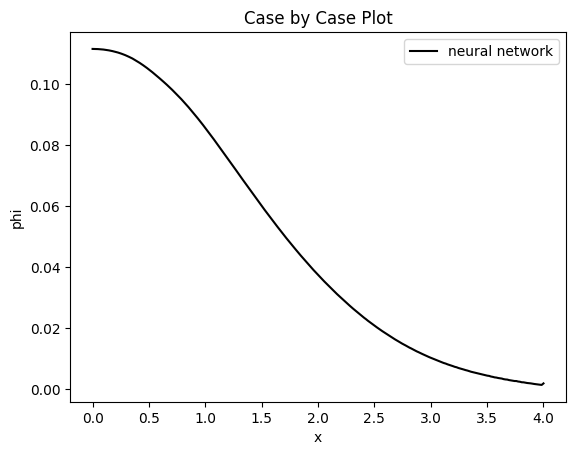

In [ ]:
# lets look at some individual test cases w/o computed data

#enter custom values
c = .9
t = 4

#normalizing
ics_case = np.array([[t,c]])
ics_case_norm = normalize(ics_case, 'l2')
ice_case_norm = ics_case_norm.transpose()

ycase = model.predict(ics_case_norm)

#plotting
import matplotlib.pyplot as plt

plt.figure(0)
plt.title("Case by Case Plot")
plt.plot(np.linspace(0, t, 250), ycase[0,:] , 'k-', label = "neural network")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.show()


**Unnormalize the results**

For actual values of phi, unnormalize both data sets and plot on a case by case basis.

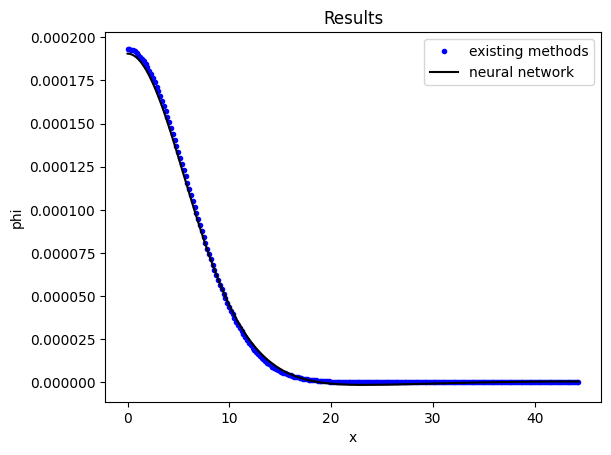

t = 44.28017 c =  0.86726123


In [ ]:
#lets unnormalize the data and integrate for various other sources
from sklearn.preprocessing import MinMaxScaler

#Using Sklearn
normalizer_x = Normalizer(norm = "l2").fit(sols)
sols_norm2 = normalizer_x.transform(sols)

#pick a case
tcase = 781

#unnormalize
phi = yhat * np.linalg.norm(sols, axis=1, keepdims=True)



plt.figure(0)
#computed data
plt.plot(solv1[tcase, :], sols[tcase] , 'b.', label = "existing methods")
#neural network
plt.plot(solv1[tcase, :], phi[tcase, :] , 'k-', label = "neural network")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.title("Results")
plt.show()
print('t =', iv1[tcase], 'c = ', iv3[tcase])

**Integrate a plane source solution to a square source solution**

Although this takes longer than simply generating the square source solution using the original numerical method, this use case could be interesting with much more complicated problems. Here the neural network's solution for a plane_IC problem is integrated to obtain the equivalent square source for a given x0, as defined in the script below.

The square source obtained by integrating the neural network is accurate with regard to both an test case solution as well as the square_IC solution with identicial initial conditons from benchmark_solutions (not shown here).

<ipython-input-23-40436558b461>:44: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  sols_square[i] = scipy.integrate.quad(integrand, -x0, x0, args = (solv1[tcase,i]))[0]
<ipython-input-23-40436558b461>:45: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  phi_square_pred[i] = scipy.integrate.quad(integrand2, -x0, x0, args = (solv1[tcase,i]))[0]
<ipython-input-23-40436558b461>:45: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrat

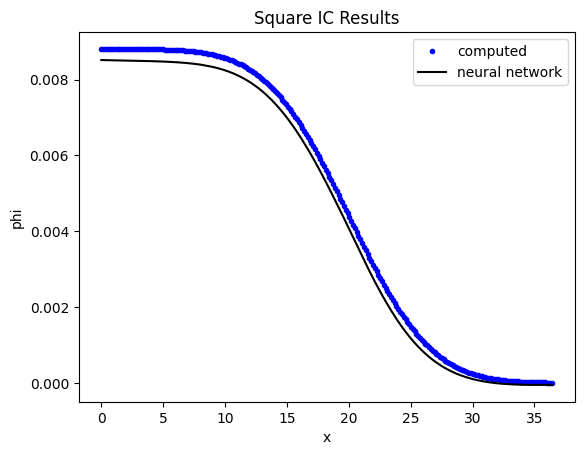

t = 36.44338 c =  0.87015843


In [ ]:
#lets convert a plane IC solution to the square IC solution
#interpolate our actual plane_IC solutions and our neural network plane_IC solutions
import scipy

#select a test case
tcase = 600
x0 = 20

#interpolate a specific case
sols_interp = scipy.interpolate.interp1d(solv1[tcase, :], sols[tcase, :])
phi_interp = scipy.interpolate.interp1d(solv1[tcase, :], phi[tcase, :])

#integrate to obtain the square source equivalent
pts = 250
sols_square = np.zeros(pts)
phi_square_pred = np.zeros(pts)


#integrate by y
def integrand(y,x):
  if x-y < solv1[tcase,:].min():
    return sols_interp(abs(x-y))
  if x-y > solv1[tcase,:].max():
    return 0
  return sols_interp(x-y)
def integrand2(y,x):
  if x-y < solv1[tcase,:].min():
    return sols_interp(abs(x-y))
  if x-y > solv1[tcase,:].max():
    return 0
  return phi_interp(x-y)

for i in range(npnts):
  sols_square[i] = scipy.integrate.quad(integrand, -x0, x0, args = (solv1[tcase,i]))[0]
  phi_square_pred[i] = scipy.integrate.quad(integrand2, -x0, x0, args = (solv1[tcase,i]))[0]



plt.figure(0)
#computed data
plt.plot(solv1[tcase, :], sols_square , 'b.', label = "computed")
#neural network
plt.plot(solv1[tcase, :], phi_square_pred, 'k-', label = "neural network")
plt.xlabel("x")
plt.ylabel("phi")
plt.legend(loc="best")
plt.title("Square IC Results")
plt.show()
print('t =', iv1[tcase], 'c = ', iv3[tcase])